In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import getcwd
import warnings
warnings.filterwarnings("ignore")
from sktime.forecasting.all import temporal_train_test_split
from sktime.forecasting.all import ExponentialSmoothing
from sktime.forecasting.all import ForecastingHorizon
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display_html
from sklearn.ensemble import RandomForestClassifier


# os.chdir('/Users/maneetsingh/Documents/University of Chicago/Financial Mathematics/4. Spring Quarter/Time Series/ts_forex_project')

### Data Pre-Processing

In [2]:
import quandl
import wrds
import functools
try:
    # Do not recreate if it already exists
    fetch_quandl
    print("fetch_quandl already defined")
except NameError:
    @functools.lru_cache(maxsize=16)
    def fetch_quandl(my_securities):
        print("Fetching from Quandl")
        qdata = quandl.get(list(my_securities), returns="pandas",
                          api_key="ZNndJ3C7Y1SBCtdKn-MP",
                          start_date='2000-01-01', end_date='2019-12-31')
        return qdata
    print("fetch_quandl has now been newly defined")

fetch_quandl has now been newly defined


In [3]:
# Interest Rate Data
rates = fetch_quandl(tuple(['YC/USA5Y','YC/FRA5Y','YC/NZL5Y','YC/GBR5Y','YC/CAN5Y','YC/JPN5Y'])).interpolate().dropna()
rates

# Read Data from CSV
forex_data = pd.read_csv('../data/Foreign_Exchange_Rates.csv', na_values='ND')

#Column Cleanup
extracted_columns = ['Time Serie', 'EURO AREA - EURO/US$', 'NEW ZEALAND - NEW ZELAND DOLLAR/US$', 'UNITED KINGDOM - UNITED KINGDOM POUND/US$', 'CANADA - CANADIAN DOLLAR/US$', 'JAPAN - YEN/US$']
named_columns = ['date', 'EURUSD', 'NZDUSD', 'GBPUSD', 'CADUSD', 'JPYUSD']
forex_data = forex_data[extracted_columns]
forex_data.columns = named_columns

# Set Date as Index
forex_data = forex_data.set_index('date')
forex_data.index = pd.to_datetime(forex_data.index) 

#Keep Only Business Days
forex_data = forex_data.interpolate().loc[rates.index.min():]

#Display Sample
display(forex_data)

Fetching from Quandl


,EURUSD,NZDUSD,GBPUSD,CADUSD,JPYUSD
date,,,,,
2004-08-20,0.81140,1.4859,0.54910,1.2980,109.320
2004-08-23,0.81990,1.4981,0.55120,1.3065,109.470
2004-08-24,0.82650,1.5328,0.55760,1.3048,109.630
2004-08-25,0.82710,1.5354,0.55660,1.3047,110.380
2004-08-26,0.82750,1.5411,0.55740,1.3123,109.730
...,...,...,...,...,...
2019-12-25,0.90145,1.5030,0.77035,1.3142,109.525
2019-12-26,0.90070,1.5002,0.76880,1.3124,109.670
2019-12-27,0.89490,1.4919,0.76390,1.3073,109.470


### Data Summary

,EURUSD,NZDUSD,GBPUSD,CADUSD,JPYUSD
# of Non-Missing Observations,"4,008.00","4,008.00","4,008.00","4,008.00","4,008.00"
Mean,0.79,1.39,0.64,1.16,103.63
Median,0.78,1.40,0.63,1.15,107.18
Minimum Value,0.62,1.13,0.47,0.92,75.72
Maximum Value,0.96,2.03,0.83,1.46,125.58


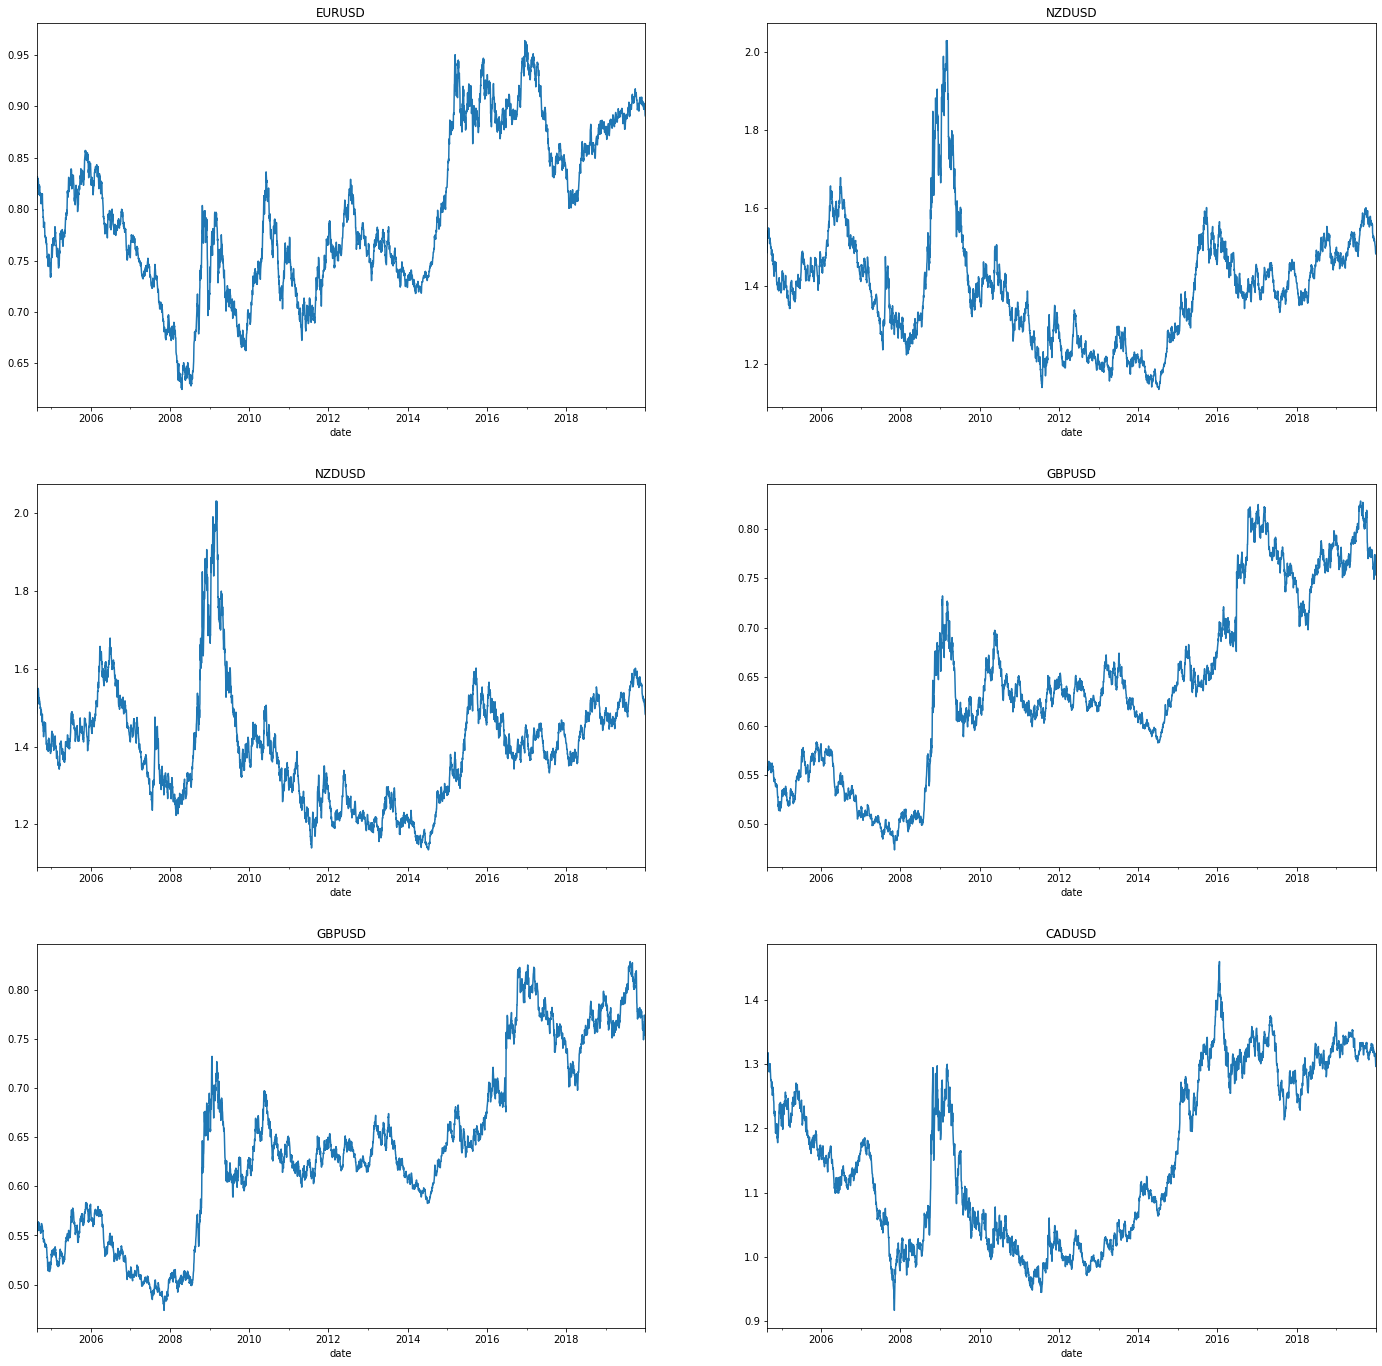

In [4]:
pa_summary = forex_data.describe()
pa_summary = pa_summary.loc[['count', 'mean', '50%', 'min', 'max']]
pa_summary.index = ['# of Non-Missing Observations', 'Mean', 'Median', 'Minimum Value', 'Maximum Value']

# Data Summary Table
display(pa_summary.style.format('{:,.2f}'))

# Data Plots
rows = 3
cols = 2
fig, ax = plt.subplots(rows, cols, figsize = (24,24))

for i in range(rows):
    for j in range(cols):
        forex_data.iloc[:,(i+j)].plot(ax = ax[i][j])
        ax[i][j].set_title(forex_data.iloc[:,(i+j)].name)

In [5]:
rates = fetch_quandl(tuple(['YC/USA5Y','YC/FRA5Y','YC/NZL5Y','YC/GBR5Y','YC/CAN5Y','YC/JPN5Y'])).interpolate().dropna()
rates

,YC/USA5Y - Rate,YC/FRA5Y - Rate,YC/NZL5Y - Rate,YC/GBR5Y - Yield,YC/CAN5Y - Rate,YC/JPN5Y - Yield
Date,,,,,,
2004-08-20,3.42,0.594002,6.140000,4.9500,3.760000,0.732
2004-08-23,3.46,0.594020,6.140000,5.0300,3.800000,0.762
2004-08-24,3.46,0.594037,6.210000,5.0300,3.850000,0.759
2004-08-25,3.46,0.594055,6.210000,4.9800,3.830000,0.789
2004-08-26,3.42,0.594072,6.190000,4.9600,3.810000,0.773
...,...,...,...,...,...,...
2019-12-25,1.72,-0.354667,1.346667,0.5510,1.633333,-0.111
2019-12-26,1.72,-0.358333,1.343333,0.5514,1.626667,-0.120
2019-12-27,1.68,-0.362000,1.340000,0.5518,1.620000,-0.120


In [6]:
data = forex_data.merge(rates,left_index=True, right_index=True)
data.head()

,EURUSD,NZDUSD,GBPUSD,CADUSD,JPYUSD,YC/USA5Y - Rate,YC/FRA5Y - Rate,YC/NZL5Y - Rate,YC/GBR5Y - Yield,YC/CAN5Y - Rate,YC/JPN5Y - Yield
2004-08-20,0.8114,1.4859,0.5491,1.2980,109.32,3.42,0.594002,6.14,4.95,3.76,0.732
2004-08-23,0.8199,1.4981,0.5512,1.3065,109.47,3.46,0.594020,6.14,5.03,3.80,0.762
2004-08-24,0.8265,1.5328,0.5576,1.3048,109.63,3.46,0.594037,6.21,5.03,3.85,0.759
2004-08-25,0.8271,1.5354,0.5566,1.3047,110.38,3.46,0.594055,6.21,4.98,3.83,0.789
2004-08-26,0.8275,1.5411,0.5574,1.3123,109.73,3.42,0.594072,6.19,4.96,3.81,0.773


In [7]:
data_gbp = data[['GBPUSD']]
data_gbp['spread'] = (data['YC/GBR5Y - Yield'])/(data['YC/USA5Y - Rate'])
data_gbp = data_gbp.resample('M').last()
data_gbp

,GBPUSD,spread
2004-08-31,0.5546,1.474474
2004-09-30,0.5528,1.417160
2004-10-31,0.5451,1.415152
2004-11-30,0.5243,1.215054
2004-12-31,0.5219,1.234160
...,...,...
2019-08-31,0.8220,0.214101
2019-09-30,0.8127,0.167290
2019-10-31,0.7729,0.268411
2019-11-30,0.7729,0.306235


In [8]:
#define KPSS
def kpss_test(data, alpha, trend='ct'):
#     print ('Results of KPSS Test: '+ label)
    kpss_output = pd.DataFrame(index=['Test Statistic','p-value','#Lags Used','Critical Value (10%)','Critical Value (5%)','Critical Value (2.5%)','Critical Value (1%)','stationarity from KPSS test'],columns = data.columns)
    for i in data.columns:
        kpsstest = kpss(data.loc[:,i], regression=trend)
        kpss_output.loc[0:3,i]= np.array(kpsstest[0:3])
        kpss_output.loc[3:7,i]= np.array(list(kpsstest[3].values()))
        kpss_output.loc['stationarity from KPSS test',i] = kpsstest[1]>=alpha
    return kpss_output

def adf_test(data,alpha):
    #Perform Dickey-Fuller test:
#     print ('Results of Dickey-Fuller Test: ' + label)
    dfoutput = pd.DataFrame(index=['Test Statistic','p-value','#Lags Used','Number of Observations Used','Critical Value (1%)','Critical Value (5%)','Critical Value (10%)','stationarity from ad_fuller test'],columns = data.columns)
    for i in data.columns:
        dftest = adfuller(data.loc[:,i], maxlag =60)
        dfoutput.loc[0:4,i]= np.array(dftest[0:4])
        dfoutput.loc[4:7,i]= np.array(list(dftest[4].values()))
        dfoutput.loc['stationarity from ad_fuller test',i] = dftest[1]<=alpha
    return dfoutput

# define modelevaluatiion matrics
def model_evaluation_metrics(ytrue,y_pred,label):
    mape = MeanAbsolutePercentageError(symmetric=False)
    smape = MeanAbsolutePercentageError()
    
    metrics = pd.DataFrame(index = ['MAE','MSE','MAPE','sMAPE'], columns = [label])
    metrics.iloc[0,0] = round(mean_absolute_error(ytrue, y_pred),5)
    metrics.iloc[1,0] = round(mean_squared_error(ytrue, y_pred),5)
    metrics.iloc[2,0] = round(mape(ytrue, y_pred),5)
    metrics.iloc[3,0] = round(smape(ytrue, y_pred),5)
    return metrics

def plot_results(y_train, y_test, y_pred):
    # plot the results
    y_train.plot(figsize = (15,7))
    y_test.plot()
    y_pred.plot()
    plt.legend(['y_train','y_test','y_pred'])
    plt.show()
    
    
def residuals_analysis(residuals):
    # residual checks
    # scatter plot of residuals
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax[0][0].scatter(residuals.index,residuals)
    ax[0][0].set_title("Scatter for residuals")
    ax[0][0].set_xlabel("Date")
    ax[0][0].set_ylabel("Residuals")
    # histogram for residuals
    ax[0][1].hist(residuals, bins=20, rwidth=0.9, color='#607c8e', density =True, align='mid',range=[-1, 1])
    ax[0][1].set_title('Histograms and KDE of residuals')
    # ACF and PACF plots
    plot_acf(residuals, lags=40, zero=False, title='residuals ACF Plot', ax =ax[1][0])
    plot_pacf(residuals, lags=40, zero=False, title='residuals PACF Plot', ax =ax[1][1])
    plt.show()

    fig.tight_layout()
    display(sm.stats.acorr_ljungbox(residuals, lags=[1,5,12,24], return_df=True, boxpierce=True))
    # summary stats of residuals
    display(residuals.describe())
    dw(residuals)
    test_shapiro_wilk(residuals, alpha=0.05)
#     test_breuschpagan(residuals, y_train.iloc[13:,1], alpha=0.05)

In [9]:
y_train, y_test = temporal_train_test_split(data_gbp.diff(1).dropna())

In [10]:
df1_styler = adf_test(y_train,0.05).style.set_table_attributes("style='display:inline'").set_caption('Results of ADF Test')
df2_styler = kpss_test(y_train,0.05).style.set_table_attributes("style='display:inline'").set_caption('Results of KPSS Test')        
space = "\xa0" * 50
display_html(df1_styler._repr_html_()+ space  + df2_styler._repr_html_(), raw=True)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,GBPUSD,spread
Test Statistic,-3.998244,-10.430445
p-value,0.001420,0.000000
#Lags Used,10.000000,1.000000
Number of Observations Used,127.000000,136.000000
Critical Value (1%),-3.482920,-3.479372
Critical Value (5%),-2.884580,-2.883037
Critical Value (10%),-2.579058,-2.578234
stationarity from ad_fuller test,True,True
,GBPUSD,spread
Test Statistic,0.071323,0.091962


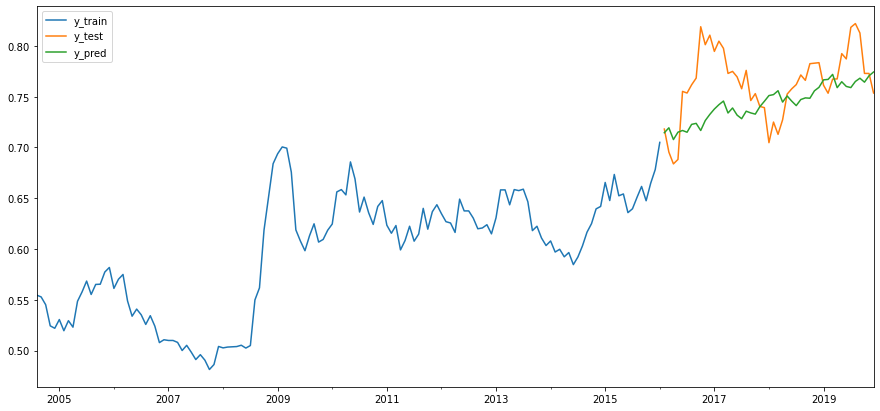

In [11]:
# model fitting
y_train, y_test = temporal_train_test_split(data_gbp)
autoarima_model = pm.auto_arima(y_train.iloc[:,0],exogenous =np.array(y_train.iloc[:,1]).reshape(-1,1),d=1, D=1,m=12, seasonality= True)
# model prediction
y_pred_autoarima = autoarima_model.predict(n_periods = len(y_test),exogenous=np.array(y_test.iloc[:,1]).reshape(-1,1))
y_pred_autoarima = pd.Series(y_pred_autoarima,index =y_test.index)
plot_results(y_train.iloc[:,0],y_test.iloc[:,0],y_pred_autoarima)

In [12]:
print(autoarima_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  138
Model:             SARIMAX(0, 1, 3)x(1, 1, [1], 12)   Log Likelihood                 334.608
Date:                              Wed, 25 May 2022   AIC                           -655.217
Time:                                      20:39:56   BIC                           -635.418
Sample:                                           0   HQIC                          -647.174
                                              - 138                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0231      0.013     -1.718      0.086      -0.049       0.003
ma.L1          0.15

In [13]:
autoarima_stat = model_evaluation_metrics(y_test.iloc[:,0],y_pred_autoarima,'Auto ARIMA_test')
autoarima_stat

,Auto ARIMA_test
MAE,0.0311
MSE,0.00144
MAPE,0.04018
sMAPE,0.04107


## Classification Model

In [21]:
data_gbp = data[['GBPUSD', 'YC/GBR5Y - Yield', 'YC/USA5Y - Rate']]
data_gbp[['YC/GBR5Y - Yield', 'YC/USA5Y - Rate']] = data_gbp[['YC/GBR5Y - Yield', 'YC/USA5Y - Rate']].shift()
data_gbp['Change in Spot'] = data_gbp['GBPUSD'].diff()
data_gbp['Direction'] = np.where(data_gbp['Change in Spot'] > 0, 1, 0)
data_gbp = data_gbp.dropna()

In [18]:
data_gbp

,GBPUSD,YC/GBR5Y - Yield,YC/USA5Y - Rate,Change in Spot,Direction
2004-08-20,0.54910,4.9500,3.42,NaN,0
2004-08-23,0.55120,5.0300,3.46,0.00210,1
2004-08-24,0.55760,5.0300,3.46,0.00640,1
2004-08-25,0.55660,4.9800,3.46,-0.00100,0
2004-08-26,0.55740,4.9600,3.42,0.00080,1
...,...,...,...,...,...
2019-12-25,0.77035,0.5510,1.72,-0.00155,0
2019-12-26,0.76880,0.5514,1.72,-0.00155,0
2019-12-27,0.76390,0.5518,1.68,-0.00490,0
2019-12-30,0.76100,0.6113,1.68,-0.00290,0


In [22]:
data_gbp

,GBPUSD,YC/GBR5Y - Yield,YC/USA5Y - Rate,Change in Spot,Direction
2004-08-23,0.55120,4.9500,3.42,0.00210,1
2004-08-24,0.55760,5.0300,3.46,0.00640,1
2004-08-25,0.55660,5.0300,3.46,-0.00100,0
2004-08-26,0.55740,4.9800,3.46,0.00080,1
2004-08-27,0.55800,4.9600,3.42,0.00060,1
...,...,...,...,...,...
2019-12-25,0.77035,0.5506,1.72,-0.00155,0
2019-12-26,0.76880,0.5510,1.72,-0.00155,0
2019-12-27,0.76390,0.5514,1.72,-0.00490,0
2019-12-30,0.76100,0.5518,1.68,-0.00290,0


In [25]:
clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
train, test = temporal_train_test_split(data_gbp)

,GBPUSD,YC/GBR5Y - Yield,YC/USA5Y - Rate,Change in Spot,Direction
2004-08-23,0.5512,4.9500,3.42,0.0021,1
2004-08-24,0.5576,5.0300,3.46,0.0064,1
2004-08-25,0.5566,5.0300,3.46,-0.0010,0
2004-08-26,0.5574,4.9800,3.46,0.0008,1
2004-08-27,0.5580,4.9600,3.42,0.0006,1
...,...,...,...,...,...
2016-02-22,0.7064,0.7634,1.24,0.0092,1
2016-02-23,0.7123,0.7556,1.25,0.0059,1
2016-02-24,0.7178,0.7634,1.23,0.0055,1
2016-02-25,0.7175,0.6946,1.21,-0.0003,0
